In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('../../tools')
from dust_extinction import calALambda
from data_binning import data_binning

z = 0.0307
t_max = 2458986.91
t_max_mjd = t_max - 2400000.5
ebv = 0.404
rv = 3.1

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

In [4]:
color_map = {
    'cyan': '#66c2a5',
    'orange': '#fc8d62',
    'blue': '#8da0cb',
    'purple': '#e78ac3',
    'green': '#a6d854',
    'yellow': '#ffd92f',
    'brown': '#e5c494'
}

In [34]:
import glob

spec_files_0 = glob.glob('../../spectroscopy/ZTF20aayhacx*ascii')
spec_files_0.sort()
spec_files = [s for s in spec_files_0 if not ('GNIRS_v' in s)]
spec_He_files = [s for s in spec_files_0 if (('Keck' in s) or ('GNIRS.' in s))]
spec_He_files_coadd_v = [s for s in spec_files_0 if ('GNIRS_v' in s)]

In [6]:
spec_files

['../../spectroscopy/ZTF20aayhacx_20200507_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200513_NOT_v4.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200521_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200528_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200529_Lick_3-m_v1.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200608_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200609_GNIRS.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200610_P200_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200623_Keck1_v1.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200915_Keck1_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20201020_Keck1_v1.ascii']

# Compare Lines

In [7]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c * ((lambda_rf / lambda_0)**2 - 1) / ((lambda_rf / lambda_0)**2 + 1)

    return v

In [8]:
def compare_lines(spec_files,
                  ax,
                  line=10830,
                  vmax=-30000,
                  vmin=0,
                  norm_fac=1,
                  bin_size=100,
                  phase_min=-np.inf,
                  phase_max=np.inf,
                  col=[],
                  instru=[]):
    '''Compare the line regions in velocity space
    '''

    from data_binning import data_binning, plot_box_spec
    from astropy.time import Time

    spec_num = -1
    for spec in spec_files:
        if 'P60' in spec:
            continue
        with open(spec) as f:
            ll = f.readlines()
        # brute force
        mjd_found = False
        for l in ll:
            if 'MJD' in l:
                mjd_found = True
                if '=' in l and 'at start' in l:
                    mjd_obs = float(l.split('=')[1].split("'")[1])
                elif '=' in l and '/' in l:
                    mjd_obs = float(l.split('=')[1].split('/')[0])
                elif '=' in l:
                    mjd_obs = float(l.split('=')[1])
                elif ':' in l:
                    mjd_obs = float(l.split(':')[1])
                break
        if not mjd_found:
            #print('Warning: MJD-obs not found in {}!'.format(spec))
            #print('Try the observation date.')
            year = 2020
            pos_dat = spec.find(str(year))
            year_obs = spec[pos_dat:pos_dat + 4]
            mon_obs = spec[pos_dat + 4:pos_dat + 6]
            date_obs = spec[pos_dat + 6:pos_dat + 8]
            try:
                mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd
            except:
                print()
        phase = (mjd_obs - t_max_mjd) / (1 + z)
        if (phase < phase_min) or (phase > phase_max):
            continue
        spec_num += 1
        spec_df = pd.read_csv(spec,
                              comment='#',
                              delim_whitespace=True,
                              header=None)

        try:
            if 'Keck' in spec:
                fl_unc0 = spec_df[3].values
            else:
                fl_unc0 = spec_df[2].values

                if 'P60' in spec or 'P200' in spec:
                    fl_unc0 **= .5
        except:
            # set relative uncertainty to be 10%
            fl_unc0 = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
                spec_df[0].values)

        wv0, fl0 = spec_df[0].values / (1 + z), spec_df[1].values
        E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
        norm = fl0[np.abs(wv0 - 8500) < 500].mean()
        fl0 *= E0 / norm
        fl_unc0 *= E0 / norm
        wv0, fl_unc0 = wv0[~np.isnan(fl0)], fl_unc0[~np.isnan(fl0)]
        fl0 = fl0[~np.isnan(fl0)]
        vel_rf0 = velocity_rf(wv0, line)

        out = data_binning(np.array([vel_rf0, fl0, fl_unc0]).T, size=bin_size)
        vel_rf_bin, fl_bin = plot_box_spec(out[:, 0], out[:, 1])
        vel_rf, fl = plot_box_spec(vel_rf0, fl0)
        fl_unc = np.repeat(fl_unc0, 2)

        if len(col) == 0:
            col = np.repeat([None], len(spec_files))

        if phase < 0:
            label = r'$-{:.1f}\ \mathrm d$'.format(np.abs(phase))
        else:
            label = r'$+{:.1f}\ \mathrm d$'.format(np.abs(phase))

        if phase > 22:
            h = 0.5 * (phase / 22)**.2
        else:
            h = 0.2
        ax.plot(vel_rf_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] / 1000,
                np.log10(fl_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] /
                         norm_fac) - spec_num * h,
                color=col[spec_num],
                linewidth=2)
        ax.plot(vel_rf[(vel_rf < vmin) & (vel_rf > vmax)] / 1000,
                np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
                spec_num * h,
                alpha=0.2,
                color=col[spec_num])
        vm = vel_rf[(vel_rf < vmin) & (vel_rf > vmax)][-1]
        arg = np.abs(vel_rf_bin - vmin + (vmin - vmax) * 0.8) < 5000
        argm = np.argmin(np.abs(vel_rf_bin - vmax))
        if arg.sum() == 0:
            arg = argm
        ax.text(vel_rf_bin[argm] / 1000,
                np.log10(fl_bin[arg].min() / norm_fac) - spec_num * h + 0.05,
                label,
                color=col[spec_num],
                va='top',
                ha='left')
        ax.text((vm + (vm - vmax) * 0.01) / 1000,
                np.log10(fl[np.argmin(np.abs(vel_rf - vmin))] / norm_fac) -
                spec_num * h,
                '${}$'.format(instru[spec_num]),
                color=col[spec_num],
                va='center')
        ax.set_xlim((vmax - (vmin - vmax) * 0.0765) / 1000,
                    (vmin + (vmin - vmax) * 0.2) / 1000)
        ax.set_ylabel(r'$\lg F_\lambda+ \mathrm{offset}$')
        #plt.fill_between(vel_rf,
        #                 fl - fl_unc, fl + fl_unc,
        #                 alpha=0.5, color=col[k + displace])
    ax.set_xlabel('$v\ [10^3\ \mathrm{km/s}]$')
    #ax.set_yticks([])

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -


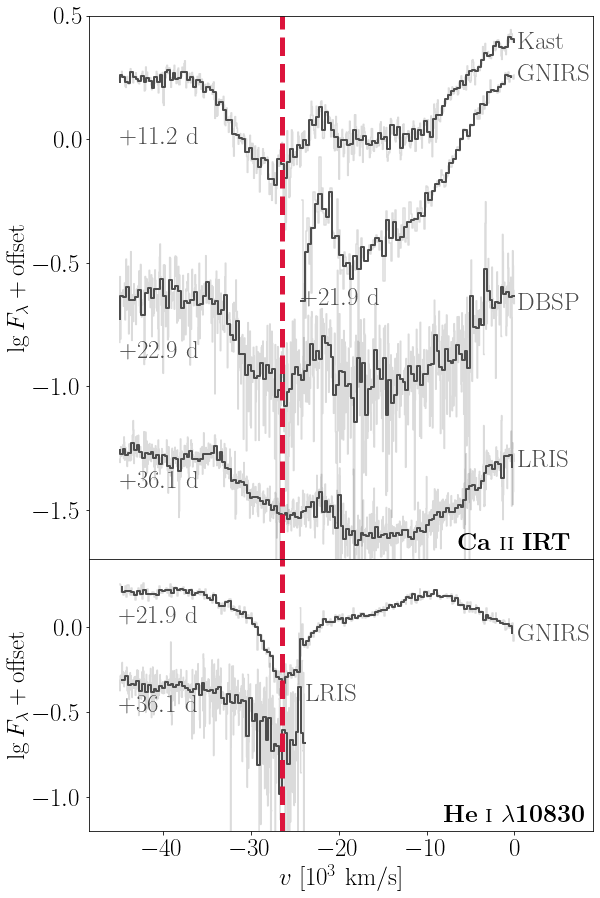

In [13]:
fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(nrows=3,
                      ncols=3,
                      left=0.05,
                      right=0.75,
                      hspace=0,
                      wspace=0.05)
ax0 = fig.add_subplot(gs[:-1, :])
ax1 = fig.add_subplot(gs[-1, :])

Ca_II_IRT = 8662.140
col_Ca = ['0.3', '0.3', '0.3', '0.3']
instru = [
    r'\mathrm{Kast}', r'\mathrm{GNIRS}', r'\mathrm{DBSP}', r'\mathrm{LRIS}'
]
compare_lines(spec_files,
              ax0,
              line=Ca_II_IRT,
              vmax=-45000,
              vmin=0,
              phase_min=11,
              phase_max=37,
              norm_fac=1,
              bin_size=300,
              col=col_Ca,
              instru=instru)
ax0.set_ylim(-1.7, 0.5)
ax0.set_xticks([])
ax0.set_xlabel('')
ax0.set_yticks([-1.5, -1, -0.5, 0, 0.5])
ax0.text(0, -1.66, r'$\mathbf{Ca\ \textsc{ii}\ IRT}$', ha='center')

HeI = 10830
col_He = ['0.3', '0.3']
instru_He = [r'\mathrm{GNIRS}', r'\mathrm{LRIS}']
compare_lines(spec_He_files,
              ax1,
              line=HeI,
              vmax=-45000,
              vmin=0,
              phase_min=11,
              phase_max=37,
              norm_fac=1,
              bin_size=300,
              col=col_He,
              instru=instru_He)
ax1.set_ylim(-1.2, 0.4)
ax1.text(0, -1.15, r'$\mathbf{He\ \textsc{i}\ \lambda 10830}$', ha='center')

ax0.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)

#plt.savefig('../../paper/figures/CaII_HeI_hvf.pdf', bbox_inches='tight')

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -


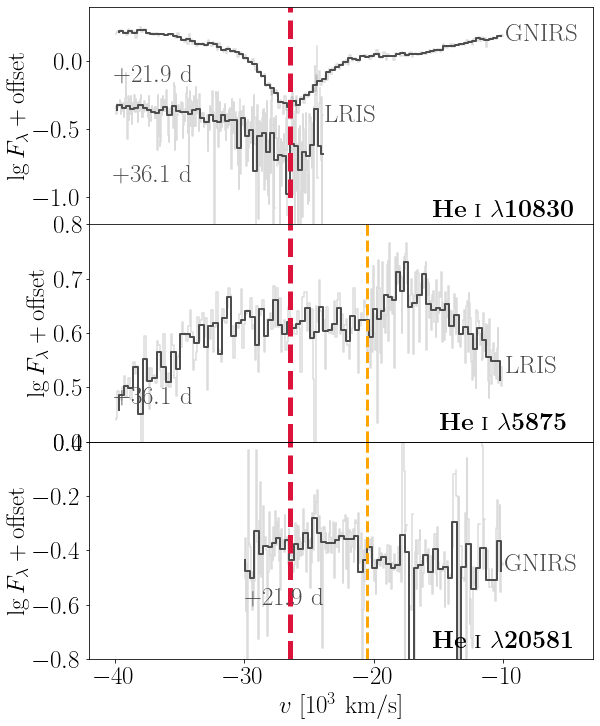

In [22]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(nrows=3,
                      ncols=3,
                      left=0.05,
                      right=0.75,
                      hspace=0,
                      wspace=0.05)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2, :])
ax2 = fig.add_subplot(gs[1, :])

spec_files_byg = glob.glob('../../spectroscopy/ZTF18aaqeasu_20180603_Keck1_v1.ascii')

HeI = 5875
col_He = ['0.3']
instru_He = [r'\mathrm{LRIS}']
compare_lines([spec_He_files[1]],
              ax2,
              line=HeI,
              vmax=-40000,
              vmin=-10000,
              phase_min=11,
              phase_max=37,
              norm_fac=1,
              bin_size=300,
              col=col_He,
              instru=instru_He)
ax2.set_ylim(0.4, 0.8)
ax2.text(-10, 0.42, r'$\mathbf{He\ \textsc{i}\ \lambda 5875}$', ha='center')
ax2.set_xticks([])
ax2.set_xlabel('')

HeI = 10830
col_He = ['0.3', '0.3', 'orange']
instru_He = [r'\mathrm{GNIRS}', r'\mathrm{LRIS}']
compare_lines(spec_He_files,
              ax0,
              line=HeI,
              vmax=-40000,
              vmin=-10000,
              phase_min=11,
              phase_max=37,
              norm_fac=1,
              bin_size=300,
              col=col_He,
              instru=instru_He)
ax0.set_ylim(-1.2, 0.4)
ax0.text(-10, -1.15, r'$\mathbf{He\ \textsc{i}\ \lambda 10830}$', ha='center')
ax0.set_xticks([])
ax0.set_xlabel('')

HeI = 20581
col_He = ['0.3']
instru_He = [r'\mathrm{GNIRS}']
compare_lines([spec_He_files[0]],
              ax1,
              line=HeI,
              vmax=-30000,
              vmin=-10000,
              phase_min=11,
              phase_max=37,
              norm_fac=.4,
              bin_size=300,
              col=col_He,
              instru=instru_He)
ax1.set_ylim(-0.8, 0)
ax1.text(-10, -0.76, r'$\mathbf{He\ \textsc{i}\ \lambda 20581}$', ha='center')

ax0.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax2.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-20.5, color='orange', linestyle='--', linewidth=3)
ax2.axvline(-20.5, color='orange', linestyle='--', linewidth=3)

for a in [ax0, ax1, ax2]:
    a.set_xlim(-42, -3)

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:99: RuntimeWarning: invalid value encountered in log10
  np.log10(fl_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] /
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:114: RuntimeWarning: invalid value encountered in log10
  np.log10(fl_bin[arg].min() / norm_fac) - spec_num * h + 0.05,
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:99: RuntimeWarning: invalid value encountered in log10
  np.log10(fl_bin[(vel_rf_bin < vmin) & (vel_rf_bin > vmax)] /
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_14044/674292347.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(fl[(vel_rf < vmin) & (vel_rf > vmax)] / norm_fac) -
/var/folders/_g/

posx and posy should be finite values
posx and posy should be finite values


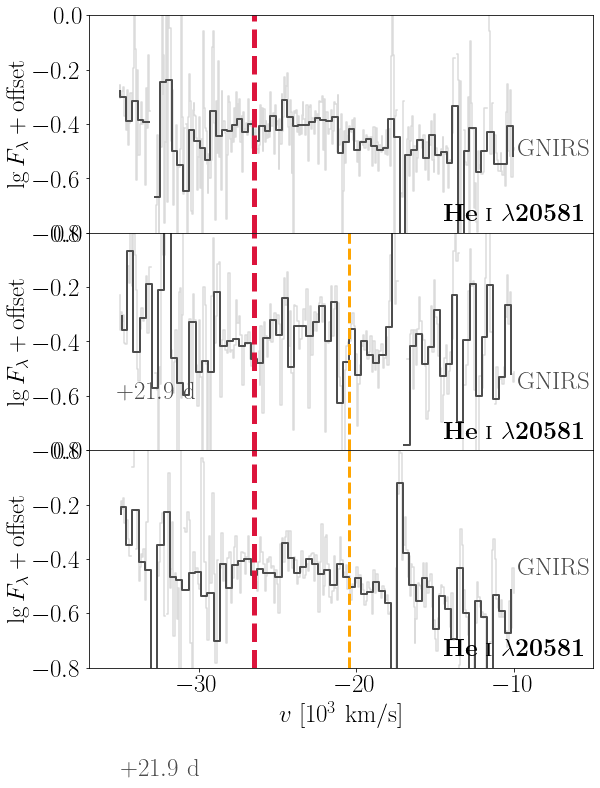

In [35]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(nrows=3,
                      ncols=3,
                      left=0.05,
                      right=0.75,
                      hspace=0,
                      wspace=0.05)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])

for k, ax in enumerate([ax0, ax1, ax2]):
    HeI = 20581
    col_He = ['0.3']
    instru_He = [r'\mathrm{GNIRS}']
    compare_lines([spec_He_files_coadd_v[k]],
                  ax,
                  line=HeI,
                  vmax=-35000,
                  vmin=-10000,
                  phase_min=11,
                  phase_max=37,
                  norm_fac=.4,
                  bin_size=300,
                  col=col_He,
                  instru=instru_He)
    ax.set_ylim(-0.8, 0)
    a.set_xlim(-27, -3)
    ax.text(-10, -0.76, r'$\mathbf{He\ \textsc{i}\ \lambda 20581}$', ha='center')

ax0.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax2.axvline(-26.5, color='crimson', linestyle='--', linewidth=5)
ax1.axvline(-20.5, color='orange', linestyle='--', linewidth=3)
ax2.axvline(-20.5, color='orange', linestyle='--', linewidth=3)